# Summarizing failure reasons
This notebook demonstrates how one can dive into summarizing error messages and failure reasones. The `_result.jsonl` files contain a column `result`, which contains a string, that in case of test failure is "failed: " and in other cases contains additionally the error message that was observed. These failures and errors can be summarized for each model as shown here.

In [1]:
import pandas as pd
import os

In [2]:
directory = "../data/"
# if you want to investigate a single model only, add its name here:
search_term = ""

# Enter the terms to search for here
common_errors = ['has no attribute', 'invalid syntax', 'is not defined', "Can't convert object", 'cannot import', 'out of range', 'unexpected keyword argument']

First we collect all results and the corresponding models from the jsonl files.

In [3]:
collection = []
for filename in os.listdir(directory):
    if search_term in filename and filename.endswith("_results.jsonl"):
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace("samples_","").replace("_results","").replace(".jsonl","")
        collection.append(df)

if len(collection) == 1:
    df = collection[0]
else:
    df = pd.concat(collection)

We then focus on the tests which failed.

In [4]:
df = df[df['passed'] == False]
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\ndef apply_otsu_threshold_and_count_postiive_...,```python\ndef apply_otsu_threshold_and_count_...,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,False,gemini-pro
1,../test_cases/binary_closing.ipynb,"\ndef binary_closing(binary_image, radius:int=...","```python\ndef binary_closing(binary_image, ra...",failed:,False,gemini-pro
2,../test_cases/binary_skeleton.ipynb,"\ndef binary_skeleton(binary_image):\n """"""\...",```python\ndef binary_skeleton(binary_image):\...,failed: The truth value of an array with more ...,False,gemini-pro
5,../test_cases/convex_hull_measure_area.ipynb,\ndef convex_hull_measure_area(point_cloud):\n...,```python\ndef convex_hull_measure_area(point_...,failed: cannot import name 'Qhull' from 'scipy...,False,gemini-pro
6,../test_cases/convolve_images.ipynb,"\ndef convolve_images(image, kernel_image):\n ...","```python\ndef convolve_images(image, kernel_i...",failed: The dimensions of the image and the ke...,False,gemini-pro
...,...,...,...,...,...,...
559,../test_cases/sum_images.ipynb,\n# Plan:\n# 1. Import the required libraries ...,```python\n# Plan:\n# 1. Import the required l...,failed: 'numpy.ndarray' object has no attribut...,False,gpt-4-1106-preview
561,../test_cases/tiled_image_processing.ipynb,\n# Plan:\n# 1. Import necessary libraries: Nu...,```python\n# Plan:\n# 1. Import necessary libr...,failed:,False,gpt-4-1106-preview
564,../test_cases/workflow_batch_process_folder_co...,\n# Plan:\n# 1. Use `os` module to access file...,```python\n# Plan:\n# 1. Use `os` module to ac...,failed: name 'np' is not defined,False,gpt-4-1106-preview
565,../test_cases/workflow_batch_process_folder_me...,\n# Plan\n# 1. Use os library to list all file...,```python\n# Plan\n# 1. Use os library to list...,failed: 'label',False,gpt-4-1106-preview


In [5]:
# Just some examples to get an idea
df.head(10)['result'].tolist()

["failed: OpenCV(4.9.0) d:\\a\\opencv-python\\opencv-python\\opencv\\modules\\imgproc\\src\\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'\n> Invalid number of channels in input image:\n>     'VScn::contains(scn)'\n> where\n>     'scn' is 1\n",
 'failed: ',
 'failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()',
 "failed: cannot import name 'Qhull' from 'scipy.spatial' (C:\\Users\\haase\\mambaforge\\envs\\heb\\lib\\site-packages\\scipy\\spatial\\__init__.py)",
 'failed: The dimensions of the image and the kernel must be the same.',
 'failed: setting an array element with a sequence.',
 'failed: ',
 "failed: name 'np' is not defined",
 'failed: ',
 "fail

## Searching for common terms
First, we search the error messages for common errors as specified above.

In [6]:
# Define the function to count errors
def count_errors(group, error_list):
    counts = {error: group['result'].str.contains(error, regex=False).sum() for error in error_list}
    return pd.Series(counts)

# Apply the function to each model group
error_counts = df.groupby('model').apply(count_errors, error_list=common_errors)

# Transpose the result for the desired format: models as columns, errors as rows
error_counts = error_counts.T

/var/folders/vz/_lv29pz53hbgcr2_ydv5dtbc0000gq/T/ipykernel_10122/939699814.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_counts = df.groupby('model').apply(count_errors, error_list=common_errors)


In [7]:
# reorder columns to be similar to evaluation result plots
with open("model_order.txt", 'r') as f:
    columns_in_order = f.readlines()
    columns_in_order = [c.strip() for c in columns_in_order if "reference" not in c]
columns_in_order

['gpt-4-turbo-2024-04-09',
 'claude-3-opus-20240229',
 'gpt-4-1106-preview',
 'gpt-3.5-turbo-1106',
 'gemini-pro',
 'codellama']

In [8]:
error_counts = error_counts[columns_in_order]
error_counts

model,gpt-4-turbo-2024-04-09,claude-3-opus-20240229,gpt-4-1106-preview,gpt-3.5-turbo-1106,gemini-pro,codellama
has no attribute,33,45,48,37,43,59
invalid syntax,0,0,1,4,0,58
is not defined,4,5,8,11,203,32
Can't convert object,1,1,3,9,3,13
cannot import,3,5,2,2,6,17
out of range,0,3,0,0,0,4
unexpected keyword argument,15,5,8,7,1,4


In [9]:
error_counts.columns = [f"\\rot{{{col}}}" for col in error_counts.columns]
error_counts

,\rot{gpt-4-turbo-2024-04-09},\rot{claude-3-opus-20240229},\rot{gpt-4-1106-preview},\rot{gpt-3.5-turbo-1106},\rot{gemini-pro},\rot{codellama}
has no attribute,33,45,48,37,43,59
invalid syntax,0,0,1,4,0,58
is not defined,4,5,8,11,203,32
Can't convert object,1,1,3,9,3,13
cannot import,3,5,2,2,6,17
out of range,0,3,0,0,0,4
unexpected keyword argument,15,5,8,7,1,4


0.13.2


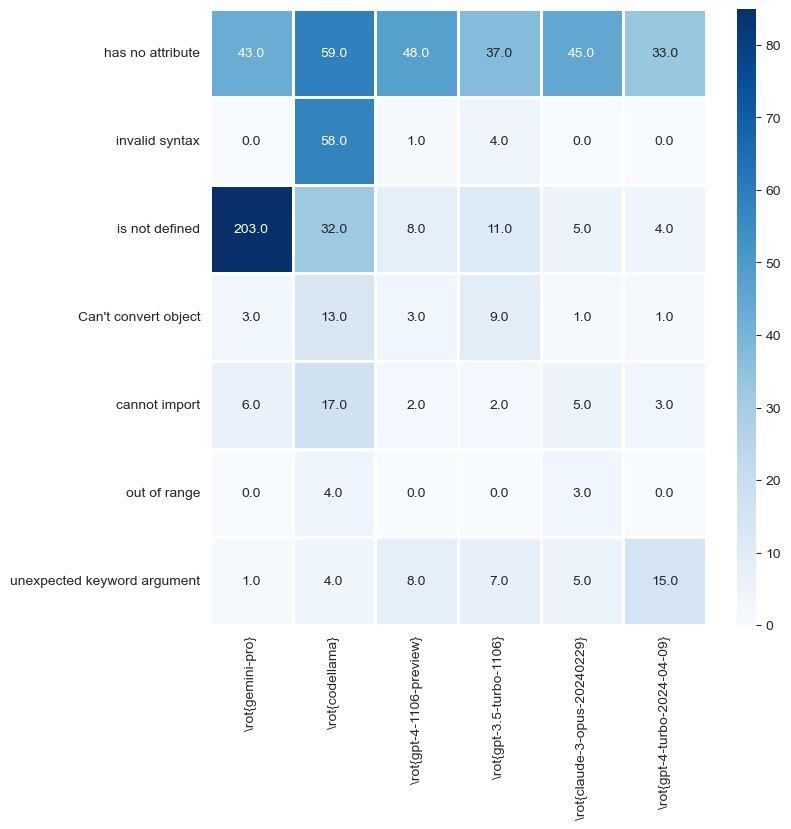

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print(sns.__version__)
sns.set_style("white")

df = error_counts

# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = df.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_data[mean_values.index]

# Plotting
fig = plt.figure(figsize=(8,8))
#plot square heatmap entries
sns.heatmap(numerical_data, annot=True, linewidths=1, fmt=".1f", cbar_kws={'shrink': 1, 'aspect': 2*16}, cmap="Blues", robust=True)

plt.savefig("../docs/paper/error_counts_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

Next we save the dataframe as tex to disk, so that we can include it in the manuscript.

In [10]:
# Convert DataFrame to TeX format string
tex_str = error_counts.to_latex()

# Define filename for the TeX file
tex_filename = '../docs/paper/error_counts_table.tex'

# Write the TeX format string to a file
with open(tex_filename, 'w') as tex_file:
    tex_file.write(tex_str)

## Most popular failure reasons
Furthermore, we search for the three most observed reasons for failure. These might be either error messages, or in case the result is only `failed: ` this indicated that the tests were not passed, presumably because the tested function did not return the right result.

In [11]:
# Step 1: Group the DataFrame by 'model' and get the value counts of 'result'
model_result_count = df.groupby('model')['result'].value_counts()

# Step 2: Create an empty DataFrame to store the results
model_top_results = []

# Step 3: Loop through each group to get the three most common results per model
for model, counts in model_result_count.groupby(level=0):
    # Get the top three results (note: nlargest returns the results)
    top_three = counts.nlargest(3)
    # Prepare data to append to the DataFrame
    data = {
        'Model': model,
        'Top1 Result': top_three.index.get_level_values(1)[0],
        'Top1 Count': top_three.iloc[0],
        'Top2 Result': top_three.index.get_level_values(1)[1] if len(top_three) > 1 else None,
        'Top2 Count': top_three.iloc[1] if len(top_three) > 1 else None,
        'Top3 Result': top_three.index.get_level_values(1)[2] if len(top_three) > 2 else None,
        'Top3 Count': top_three.iloc[2] if len(top_three) > 2 else None
    }
    # Append data
    model_top_results.append(data)

# Display the resulting DataFrame
most_common_errors = pd.DataFrame(model_top_results)
most_common_errors

,Model,Top1 Result,Top1 Count,Top2 Result,Top2 Count,Top3 Result,Top3 Count
0,claude-3-opus-20240229,failed:,164,failed: 'list' object has no attribute 'shape',23,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,11
1,codellama,failed:,98,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,26,"failed: invalid syntax (<string>, line 4)",22
2,gemini-pro,failed: name 'np' is not defined,152,failed:,96,failed: 'list' object has no attribute 'shape',17
3,gpt-3.5-turbo-1106,failed:,152,failed: OpenCV(4.9.0) D:\a\opencv-python\openc...,19,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,16
4,gpt-4-1106-preview,failed:,141,failed: 'list' object has no attribute 'shape',16,failed: 'numpy.ndarray' object has no attribut...,12
5,gpt-4-turbo-2024-04-09,failed:,153,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,15,failed: 'list' object has no attribute 'shape',14
